# This notebook solves the Huggett Model (1993) using Dolo.

This is a heterogeneous-agent model where each period agents are hit with idiosyncratic income shocks $y_t$ that follow an $AR1$ process. There are incomplete markets and agents only have access to a risk-free asset $s_t$ that pays $(1+r)s_t$ next period, where $r$ is the interest rate.

The value function for an agent with current assets $s$ and current income $y$ is: $v(y,s)=\max_{c,s'} u(c)+\beta \mathbf{E}v(y',s')$ where the expectation is taken over the value of the income shock.

The agent's budget constraint is: $c+s'=(1+r)s+y$ where s' is his asset choice next period. The agent will also be subject to a borrowing constraint: $s'\geq \bar{s}$.

Here, we define the control in the model as $a=s'-s$, i.e. $a$ is the change in assets.


In [1]:
# First import the packages
Pkg.dir("Dolo")
import Dolo
using AxisArrays
using PyPlot

. To use SymEngine call Pkg.add("SymEngine")


In [2]:
# get the model file
filename=("huggett_1993.yaml")

"huggett_1993.yaml"

In [3]:
# Convert the file into Dolo model
model=Dolo.yaml_import(filename)

Model 


MethodError: MethodError: no method matching sanitize(::Expr, ::Dolo.Model{Symbol("##336")})[0m
Closest candidates are:
  sanitize(::Expr, [1m[31m::Array{Symbol,1}[0m) at C:\Users\Angela\AppData\Local\JuliaPro-0.5.1.1\pkgs-0.5.1.1\v0.5\Dolo\src\printing.jl:14
  sanitize(::Any, [1m[31m::Array{Symbol,1}[0m) at C:\Users\Angela\AppData\Local\JuliaPro-0.5.1.1\pkgs-0.5.1.1\v0.5\Dolo\src\printing.jl:3
  sanitize(::Any, [1m[31m::Dolo.SModel{ID}[0m) at C:\Users\Angela\AppData\Local\JuliaPro-0.5.1.1\pkgs-0.5.1.1\v0.5\Dolo\src\printing.jl:32[0m

Now let's look at solving the model. We will use Dolo's time iteration function (which iterates on the residuals of the arbitrage equation).

In [4]:
@time sol=Dolo.time_iteration(model,verbose=true, maxit=1000, details=true)
dr=sol.dr
@time res = Dolo.time_iteration(model, dr; maxit=200, details=true)

It    SA          gain        nit  
-----------------------------------
0     1.11e+00    NaN         0    
1     1.42e+00    1.28e+00    5    
2     8.12e-01    5.71e-01    4    
3     4.94e-01    6.08e-01    4    
4     3.19e-01    6.46e-01    4    
5     2.16e-01    6.79e-01    3    
6     1.53e-01    7.05e-01    3    
7     1.11e-01    7.27e-01    3    
8     8.27e-02    7.45e-01    3    
9     6.29e-02    7.61e-01    3    
10    4.87e-02    7.74e-01    3    
11    3.82e-02    7.85e-01    3    
12    3.04e-02    7.95e-01    3    
13    2.54e-02    8.36e-01    3    
14    2.38e-02    9.35e-01    3    
15    2.25e-02    9.49e-01    2    
16    2.11e-02    9.35e-01    2    
17    1.98e-02    9.40e-01    2    
18    1.86e-02    9.41e-01    2    
19    1.73e-02    9.30e-01    2    
20    1.63e-02    9.40e-01    2    
21    1.51e-02    9.29e-01    2    
22    1.41e-02    9.33e-01    2    
23    1.31e-02    9.29e-01    2    
24    1.22e-02    9.29e-01    2    
25    1.13e-02    9.30e-01  

Results of Time Iteration Algorithm
 * Complementarities: true
 * Decision Rule type: Dolo.TimeIterationResult
 * Number of iterations: 1
 * Convergence: true
   * |x - x'| < 1.0e-08: true


Dolo tabulate gives us the decision rules.

In [5]:
drtab = Dolo.tabulate(model, dr, :s) 

2-dimensional AxisArray{Float64,2,...} with axes:
    :V, Symbol[:lny,:s,:a]
    :s, [-2.0,-1.77778,-1.55556,-1.33333,-1.11111,-0.888889,-0.666667,-0.444444,-0.222222,0.0  …  18.0,18.2222,18.4444,18.6667,18.8889,19.1111,19.3333,19.5556,19.7778,20.0]
And data, a 3×100 Array{Float64,2}:
  0.0        0.0        0.0        0.0      …   0.0        0.0        0.0    
 -2.0       -1.77778   -1.55556   -1.33333     19.5556    19.7778    20.0    
  0.271821   0.241945   0.212451   0.18372     -0.897489  -0.905228  -0.91296

Now we plot the consumption policy function. We see that it is concave because of the precautionary savings motive noting as well that there is more curvature closer to the borrowing constraint.

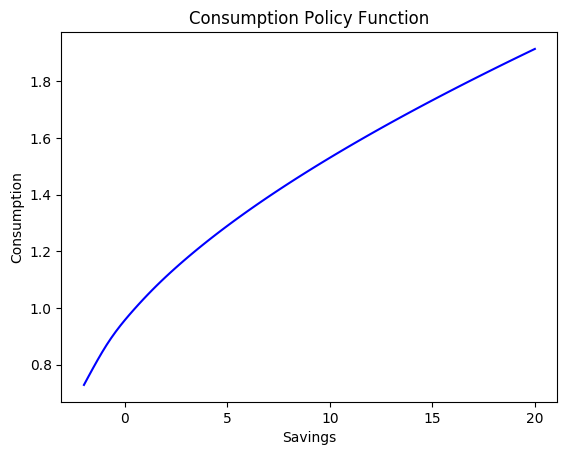

PyObject <matplotlib.text.Text object at 0x00000000241166D8>

In [12]:
# Plot the consumption policy function
import PyPlot
plt=PyPlot
r=model.calibration.flat[:r]
c=exp(drtab[Axis{:V}(:lny)])+drtab[:s]*r-drtab[Axis{:V}(:a)]

plt.plot(drtab[Axis{:V}(:s)],c, color="blue")
plt.xlabel("Savings")
plt.ylabel("Consumption")
plt.title("Consumption Policy Function")

### Simulations

Here we run simulations for N agents and look at the asset distribution.

In [40]:
# Simulations
import PyPlot
plt=PyPlot


mc_ar=model.exogenous

sim_armc = Dolo.simulate(model,dr;N=1000,T=200)


T=200

200

In [41]:
N=1000
n=200 # number of periods to plot
hor=linspace(1,n,n)
function plot_simulations(N::Int64,T::Int64,n::Int64,sim_armc)
    assets_end=zeros(N)
    for ii=1:N # number of simulations
      c=exp(sim_armc[Axis{:N}(ii), Axis{:V}(:lny)])[T-n+1:T]+sim_armc[Axis{:N}(ii), Axis{:V}(:s)][T-n+1:T]*r-sim_armc[Axis{:N}(ii), Axis{:V}(:a)][T-n+1:T]
      
        assets_end[ii]=exp(sim_armc[Axis{:N}(ii), Axis{:V}(:lny)])[T]-c[end]
    
    end

    return assets_end
end




plot_simulations (generic function with 1 method)

In [42]:
assets_end=plot_simulations(N,T,n,sim_armc);

, Int64, Int64, Any) in module Main at In[30]:5 overwritten

We see that the average asset holdings is very close to zero so we have market clearing.


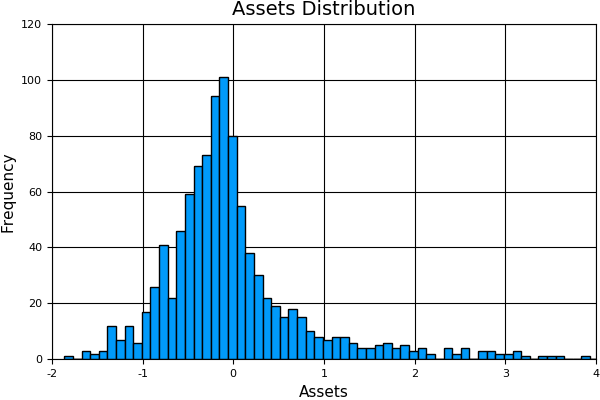

In [45]:
using Plots
histogram(assets_end,nbins=80,xlims=(-2.0,4.0), ylims=(0.0,120.0), label="", xlabel="Assets", ylabel="Frequency", title="Assets Distribution")


In [46]:
mean(assets_end)

-0.00468303900072091